In [21]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [25]:
import numpy as np
import pandas as pd
import umap
from sklearn.datasets import make_classification

np.random.seed(seed=42) 

In [102]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


param_grid = [
    {"dual":[False],"max_iter":[10000000], "penalty":["l1","l2"], "tol":[1e-4], "C":[1,10]},
    { "max_iter":[10000000], "loss":["squared_hinge", "hinge"], "tol":[1e-4], "C":[1,10]}
]

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM",LinearSVC(**{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l2', 'tol': 0.0001}))
])

def runSVM(X,y, X_valid,y_valid):
    
    clf_grid = Pipeline([
        ("scaler", StandardScaler()),
        ("SVMGrid",GridSearchCV(LinearSVC(), param_grid, cv=10, iid=False, scoring="neg_mean_squared_error", n_jobs=4))
    ])
    
    clf_grid.fit(X, y)
    grid = clf_grid.steps[1][1]
    print(grid.best_params_)

    svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("SVM", LinearSVC(**grid.best_params_))
    ])
    
    svm_clf.fit(X, y)
    print("SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_valid, y_valid)))

    _score = cross_val_score(svm_clf, X=X, y=y, cv=10)
    print("SVM CV Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))
    
    return svm_clf, grid.best_params_

In [97]:
X,y = make_classification(n_samples=3000, n_classes=3, n_informative=3, class_sep=1.75, n_clusters_per_class=2, random_state=42)

In [142]:
reducer = umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=50,
                    min_dist=0.1)
embedding = reducer.fit_transform(X)

In [143]:
emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Training",
    marker=dict(
        size=3,
        color=y,
        colorscale="Viridis",
        showscale=True,
        opacity=0.8
    ),
    text=y
)

layout = go.Layout(
    title="3D LRP Embedding",
    autosize=False,
    width=1200,
    height=1000,
    paper_bgcolor='#F5F5F5'
)


pltdata=[emb3d]

fig = go.Figure(data=pltdata, layout=layout)
iplot(fig, filename='lrp-3d-heart.html')

In [100]:
from helper import split_valid, plot_confusion_matrix
from sklearn.metrics import classification_report

data = pd.DataFrame(X)
labels = pd.Series(y)

X_train, y_train, X_valid, y_valid = split_valid(data, labels, valid_size=0.2)

In [103]:
%time clf.fit(X_train, y_train)
print("SVM Test Accuracy: {:0.3f}".format(clf.score(X_valid, y_valid)))

CPU times: user 14.6 ms, sys: 1.53 ms, total: 16.1 ms
Wall time: 15 ms
SVM Test Accuracy: 0.682


In [104]:
original_svm, orig_best_params = runSVM(X_train, y_train, X_valid, y_valid)

{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l1', 'tol': 0.0001}
SVM Test Accuracy: 0.680
SVM CV Accuracy: 0.697(+/- 0.050)


In [105]:
y_pred = original_svm.predict(X_valid)
target_names = np.array(["A","B","C"])
print(classification_report(y_valid.values, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           A       0.61      0.81      0.70       199
           B       0.63      0.31      0.42       199
           C       0.78      0.92      0.84       202

    accuracy                           0.68       600
   macro avg       0.67      0.68      0.65       600
weighted avg       0.67      0.68      0.65       600



Confusion matrix, without normalization
[[0.80904523 0.15075377 0.04020101]
 [0.46733668 0.31155779 0.22110553]
 [0.04950495 0.03465347 0.91584158]]
Overall Accuracy: 0.6800


(<matplotlib.axes._subplots.AxesSubplot at 0x1a2fe73668>,
 array([[161,  30,   8],
        [ 93,  62,  44],
        [ 10,   7, 185]]))

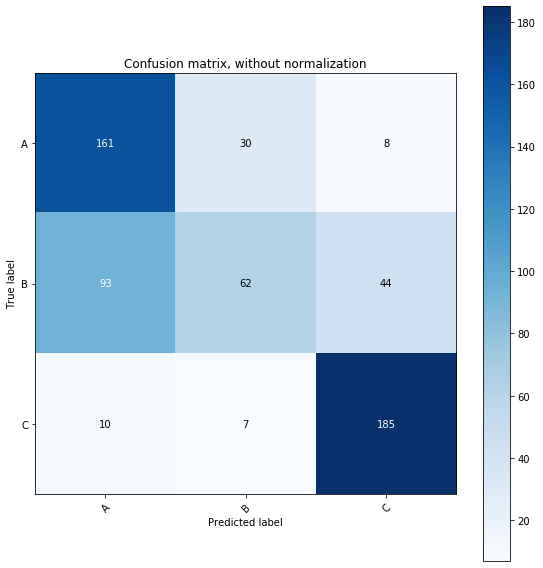

In [106]:
plot_confusion_matrix(y_valid.values, y_pred.astype(int), target_names)

# Looking at subclusters separated

## A vs B

CPU times: user 5.8 ms, sys: 157 µs, total: 5.95 ms
Wall time: 6.03 ms
SVM Test Accuracy: 0.757
              precision    recall  f1-score   support

           A       0.86      0.69      0.77       200
           B       0.74      0.89      0.81       199

    accuracy                           0.79       399
   macro avg       0.80      0.79      0.79       399
weighted avg       0.80      0.79      0.79       399

Confusion matrix, without normalization
[[0.695      0.305     ]
 [0.11055276 0.88944724]]
Overall Accuracy: 0.7920


(<matplotlib.axes._subplots.AxesSubplot at 0x1a2fe067f0>, array([[139,  61],
        [ 22, 177]]))

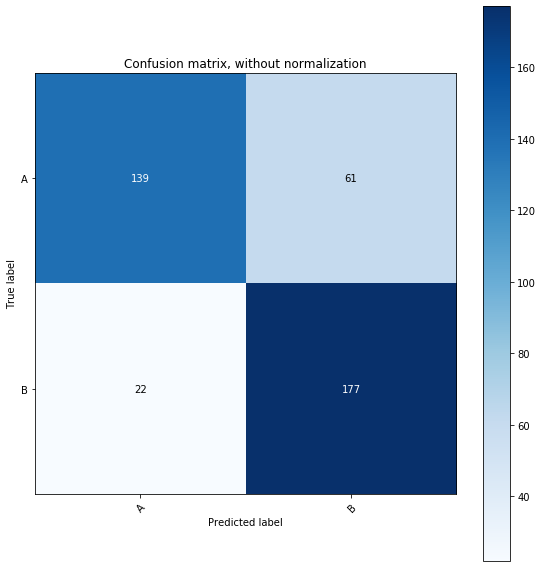

In [116]:
bi_data = data[labels<2]
bi_labels = labels[labels<2]

bi_train, bi_y_train, bi_valid, bi_y_valid = split_valid(bi_data, bi_labels, valid_size=0.2)

%time clf.fit(bi_train, bi_y_train)
print("SVM Test Accuracy: {:0.3f}".format(clf.score(bi_valid, bi_y_valid)))

# bi_svm, bi_best_params = runSVM(bi_train, bi_y_train, bi_valid, bi_y_valid)
# {'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}

y_pred =  bi_svm.predict(bi_valid)
target_names = np.array(["A","B"])
print(classification_report(bi_y_valid.values, y_pred, target_names=target_names))

plot_confusion_matrix(bi_y_valid.values, y_pred.astype(int), target_names)

## B vs C

CPU times: user 4.91 ms, sys: 591 µs, total: 5.5 ms
Wall time: 4.89 ms
SVM Test Accuracy: 0.860
              precision    recall  f1-score   support

           B       0.87      0.84      0.86       199
           C       0.85      0.88      0.86       202

    accuracy                           0.86       401
   macro avg       0.86      0.86      0.86       401
weighted avg       0.86      0.86      0.86       401

Confusion matrix, without normalization
[[0.83919598 0.16080402]
 [0.11881188 0.88118812]]
Overall Accuracy: 0.8603


(<matplotlib.axes._subplots.AxesSubplot at 0x1a324b7358>, array([[167,  32],
        [ 24, 178]]))

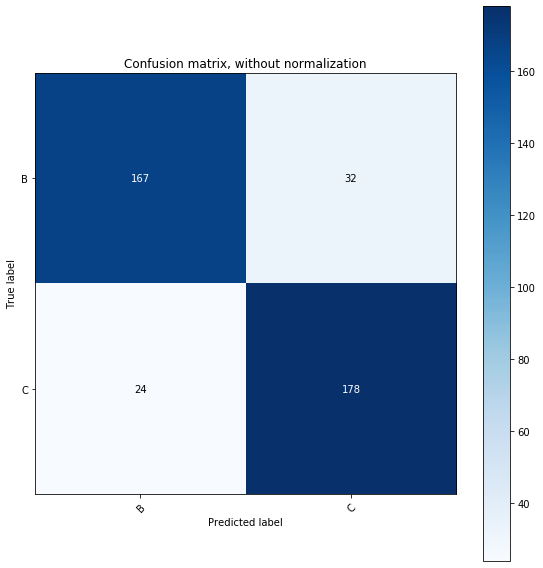

In [132]:
bi_data = data[labels>0]
bi_labels = labels[labels>0]

bi_train, bi_y_train, bi_valid, bi_y_valid = split_valid(bi_data, bi_labels, valid_size=0.2)

%time clf.fit(bi_train, bi_y_train)
print("SVM Test Accuracy: {:0.3f}".format(clf.score(bi_valid, bi_y_valid)))

# %time bi_svm, bi_best_params = runSVM(bi_train, bi_y_train, bi_valid, bi_y_valid)
# {'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
bi_svm=clf
y_pred =  bi_svm.predict(bi_valid)
correct_BC = bi_y_valid[y_pred == bi_y_valid]

target_names = np.array(["B","C"])
print(classification_report(bi_y_valid.values, y_pred, target_names=target_names))

target_names = np.array(["A","B","C"])
plot_confusion_matrix(bi_y_valid.values, y_pred.astype(int), target_names)

## A vs C

CPU times: user 5.01 ms, sys: 379 µs, total: 5.39 ms
Wall time: 5.48 ms
SVM Test Accuracy: 0.975
{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l2', 'tol': 0.0001}
SVM Test Accuracy: 0.975
SVM CV Accuracy: 0.984(+/- 0.013)
CPU times: user 142 ms, sys: 5.91 ms, total: 148 ms
Wall time: 2.53 s
              precision    recall  f1-score   support

           A       0.97      0.97      0.97       199
           C       0.98      0.98      0.98       202

    accuracy                           0.98       401
   macro avg       0.98      0.98      0.98       401
weighted avg       0.98      0.98      0.98       401

Confusion matrix, without normalization
[[0.97487437 0.02512563]
 [0.02475248 0.97524752]]
Overall Accuracy: 0.9751


(<matplotlib.axes._subplots.AxesSubplot at 0x1a2e24ebe0>, array([[194,   5],
        [  5, 197]]))

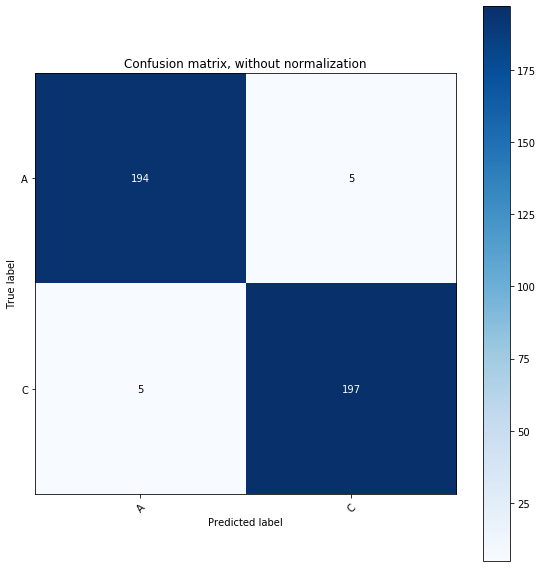

In [137]:
bi_data = data[labels != 1]
bi_labels = labels[labels != 1]

bi_train, bi_y_train, bi_valid, bi_y_valid = split_valid(bi_data, bi_labels, valid_size=0.2)

%time clf.fit(bi_train, bi_y_train)
print("SVM Test Accuracy: {:0.3f}".format(clf.score(bi_valid, bi_y_valid)))

%time bi_svm, bi_best_params = runSVM(bi_train, bi_y_train, bi_valid, bi_y_valid)
# {'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}

y_pred =  bi_svm.predict(bi_valid)
correct_AC = bi_y_valid[y_pred == bi_y_valid]

target_names = np.array(["A","C"])
print(classification_report(bi_y_valid.values, y_pred, target_names=target_names))

target_names = np.array(["A","B","C"])
plot_confusion_matrix(bi_y_valid.values, y_pred.astype(int), target_names)

In [154]:
C_idxs_1 = set(correct_BC[correct_BC == 2].index)
C_idxs_2 = set(correct_AC[correct_AC == 2].index)

C_total = C_idxs_1.union(C_idxs_2)
print("Number of C samples predicted:", len(C_total))
print("Ratio:", len(C_total)/y_valid.value_counts()[2])

Number of C samples predicted: 197
Ratio: 0.9752475247524752


In [141]:
C_total - C_idxs_2

set()

## By looking at these observations, we have evidence that the dataset will perform well for our analysis
## The initial binary classification should be (A v B) vs C
## The results above show us that A vs C and B vs C should both perform better